<a href="https://colab.research.google.com/github/luisaleite/Curriculo/blob/main/recomedantio_Sprint_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Descrição da Base de Dados**

Esse dataset teve como sua base o banco de dados público apresentado pelo professor neste link "https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset", usamos a tabela "ratings.csv" para extrairmos os dados e analisá-los.

Existem três colunas nesse arquivo csv (https://docs.google.com/spreadsheets/d/1MxirctwS0bSZLEa1V-GccaWkCSS9p6QDZQjOMd3-FqQ/edit?usp=sharing):
- userId: a identificação do usuario dentro da plataforma;
- Itemid: a identificação do item (post) dentro da plataforma;
- classification: a classificação desse item dada pelo o tal usuario, a nota varia de 0 até 5.

Resumindo são três colunas com 100836 linhas, sem nenhum dado ausente, e esta balanceado e não possuem nenhum dado discrepante conforme mostra os dois gráficos presente no notebbok. As três classificações mais comum no dataset são:

- **4.0 com 26818**

- **3.0 com 20047**

- **5.0 com 13211**
- 3.5 com 13136
- 4.5 com 8551
- 2.0 com 7551
- 2.5 com 5550
- 1.0 com 2811
- 1.5 com 1791
- 0.5 com 1370

Com isso podemos ver que na coluna classification (nossa coluna alvo) não possue discrepâncias.





In [ ]:
!pip install -U -q PyDrive

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1lfDv4PKcSJXfIwJh3m902XNHUQUAuD9t'})
downloaded.GetContentFile('BaseDados_G1-BaseDados_G1.csv')

ratings = pd.read_csv("BaseDados_G1-BaseDados_G1.csv")

In [ ]:
ratings.shape

(100836, 3)

In [ ]:
ratings.head(100)

,userId,Itemid,classification
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
95,1,1445,3.0
96,1,1473,4.0
97,1,1500,4.0
98,1,1517,5.0


In [ ]:
ratings.describe()

,userId,Itemid,classification
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [ ]:
valores_ausentes = ratings.isnull().sum()

print(valores_ausentes)

userId            0
Itemid            0
classification    0
dtype: int64


In [ ]:
contagem_valores = ratings['classification'].value_counts()

# Exibir a contagem de valores
print(contagem_valores)

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: classification, dtype: int64


<Axes: >

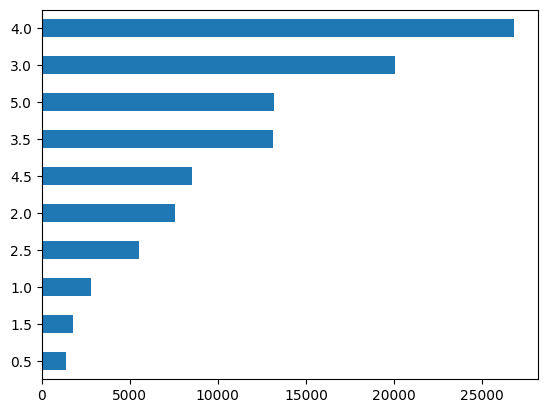

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ratings.classification.value_counts().sort_values().plot(kind='barh')

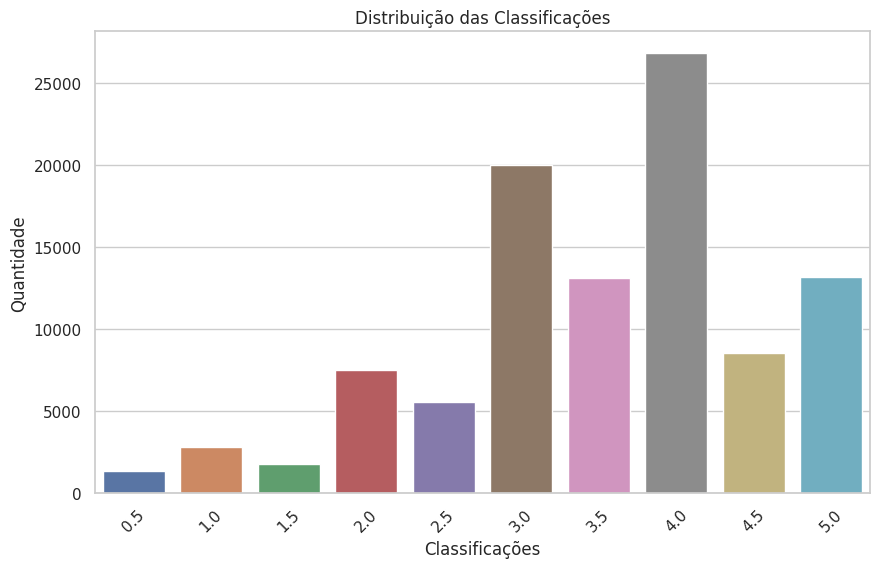

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar os dados
ratings = pd.read_csv("BaseDados_G1-BaseDados_G1.csv")  # Substitua pelo caminho do seu arquivo CSV

# Contar o número de amostras em cada classe
contagem_classes = ratings['classification'].value_counts()

# Configurar estilo do gráfico
sns.set(style="whitegrid")

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))  # Define o tamanho da figura
sns.barplot(x=contagem_classes.index, y=contagem_classes.values)

# Configurar rótulos e título
plt.xlabel('Classificações')
plt.ylabel('Quantidade')
plt.title('Distribuição das Classificações')

# Rotacionar rótulos do eixo x, se necessário
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()


Apartir de agora precisamos montar o modelo que é o iten-KNN que é um método que encontra itens semelhantes com base em suas características e histórico de preferências de outros usuários. Esse algoritmo é amplamente utilizado em sistemas de recomendação, onde o objetivo é oferecer aos usuários sugestões personalizadas de itens com base em seus interesses e preferências anteriores.

**Então para podermos realizar esse método precisamos de outra tabela além de "ratings.csv", precisamos utilizar a tabela "movies.csv", para treinar o modelo.**

Esse arquivo (https://docs.google.com/spreadsheets/d/1c6wHiD2ZODKa7ZFZ1h17kUdKJchhmLJ7uwspkDkA24c/edit?usp=sharing) tem duas colunas a primeira é "ItemId" que também tem na "ratings.csv", a segunda é "title" que são os nomes dos filmes.



In [ ]:
downloaded = drive.CreateFile({'id': '1mXNfrxWtD0Z_01yt21tOj_1Hu14r8ExK'})
downloaded.GetContentFile('BaseDadosMovies_G1.csv')
movies = pd.read_csv("BaseDadosMovies_G1.csv")

In [ ]:
movies.head()

,Itemid,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
final_dataset = ratings.pivot(index='Itemid',columns='userId',values='classification')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
Itemid,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
Itemid,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


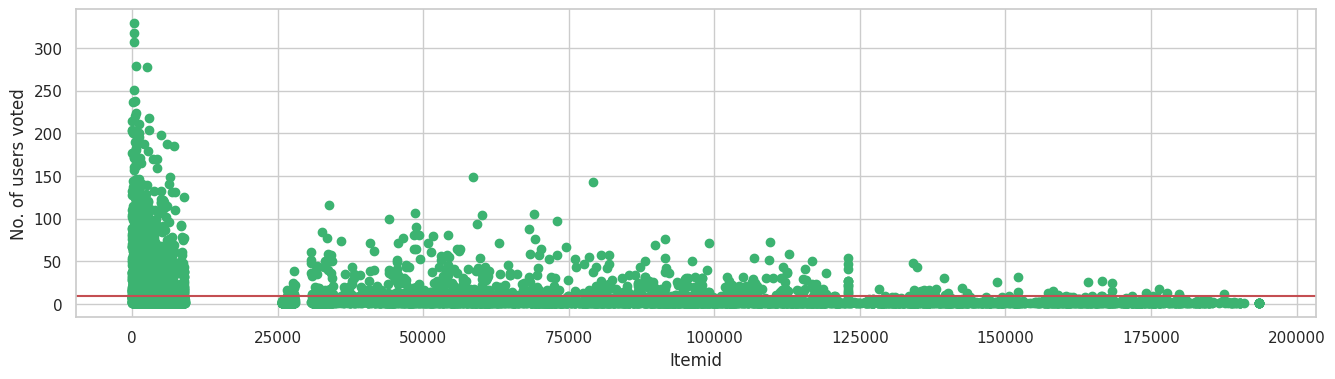

In [ ]:
no_user_voted = ratings.groupby('Itemid')['classification'].agg('count')
no_movies_voted = ratings.groupby('userId')['classification'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('Itemid')
plt.ylabel('No. of users voted')
plt.show()

In [ ]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

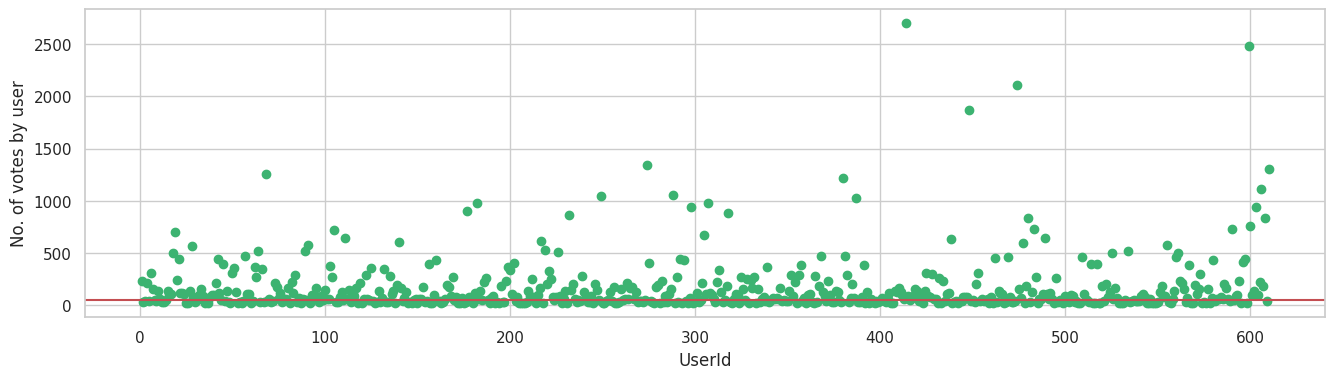

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [ ]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
Itemid,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [ ]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


In [ ]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [ ]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]
    if len(movie_list):
        movie_idx= movie_list.iloc[0]['Itemid']
        movie_idx = final_dataset[final_dataset['Itemid'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['Itemid']
            idx = movies[movies['Itemid'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [ ]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Up (2009),0.368857
2,Guardians of the Galaxy (2014),0.368758
3,Watchmen (2009),0.368558
4,Star Trek (2009),0.366029
5,Batman Begins (2005),0.362759
6,Avatar (2009),0.310893
7,Iron Man 2 (2010),0.307492
8,WALL·E (2008),0.298138
9,"Dark Knight, The (2008)",0.285835
10,"Avengers, The (2012)",0.285319


**Agora chegamos na parte de de comunicação assíncrona, no momento usaremos o MQTT, que utiliza o mesmo paradigma publish-subscribe do Kafka. Com auxilio desse site (https://www.hivemq.com/demos/websocket-client/) para mostrar a comunicação da IA com a web.**



In [ ]:
! pip install paho-mqtt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for paho-mqtt: filename=paho_mqtt-1.6.1-py3-none-any.whl size=62118 sha256=025d7fd281eb21ea069fb99efd6597ce5e74b6db1bd51c90c262bef629aaae58
  Stored in directory: /root/.cache/pip/wheels/8b/bb/0c/79444d1dee20324d442856979b5b519b48828b0bd3d05df84a
Successfully built paho-mqtt


In [ ]:
import time
import paho.mqtt.client as paho

In [ ]:
def on_message(client, userdata, message):

    recommendation = get_movie_recommendation(str(message.payload.decode("utf-8")))

    time.sleep(1)
    print("received message =",str(message.payload.decode("utf-8")))
    print("received recommendation =", recommendation)


    print("publishing:")

    client.publish("intelies-grupo1-publish", str(recommendation))
    time.sleep(4)

In [ ]:
broker="mqtt-dashboard.com"

#create client object client1
client= paho.Client("client-424823hghi8878")

#Bind function to callback
client.on_message=on_message

print("connecting to broker ",broker)
client.connect(broker) #connect

#subscribe
print("subscribing ")
client.subscribe("intelies-grupo1")
time.sleep(2)


# client.loop_start() #start loop to process received messages

client.loop_forever()

#publish
# print("publishing ")
# client.publish("inteli/es","on")
# time.sleep(4)

# client.disconnect() #disconnect
# client.loop_stop() #stop loop

connecting to broker  mqtt-dashboard.com
subscribing 
received message = sdfsfsfs
received recommendation = No movies found. Please check your input
publishing:


KeyboardInterrupt: ignored